## ACC: Predicting gym injuries

#### Step-by-Step Implementation in Python
     
The following code demonstrates:
  1. Data ingestion and cleaning
  2. Basic exploratory data analysis (EDA)
  3. Feature engineering
  4. Train/test split
  5. Model building (using Logistic Regression)
  6. Model evaluation
  7. Ranking individuals by predicted risk

1. IMPORT REQUIRED PACKAGES


In [1]:
# 1. IMPORT REQUIRED PACKAGES
# -------------------------------------------------------------
import pandas as pd
import numpy as np

# For EDA and plotting (optional)
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# For encoding categorical variables
from sklearn.preprocessing import LabelEncoder

2. DATA INGESTION


In [2]:
# 2. DATA INGESTION
# -------------------------------------------------------------
# Read the dataset 
gym_injuries_df = pd.read_csv("DataForExercise.csv")

3. INITIAL DATA INSPECTION & CLEANING

In [3]:
# 3. INITIAL DATA INSPECTION & CLEANING
# -------------------------------------------------------------
# Check the first few rows
print(gym_injuries_df.head())

# Inspect basic info (column names, dtypes, missing values)
print(gym_injuries_df.info())

# let's rename our target variable (y) with a better name (outcome)
gym_injuries_df.rename(columns={'y': 'outcome'}, inplace=True)

# Check the distribution of the target variable
print(gym_injuries_df['outcome'].value_counts())


   PersonACCId  age_at_extraction_date ethnicity_last_claim  \
0            1                    25.0             European   
1            2                    29.0                Maori   
2            3                    50.0             European   
3            4                    28.0             European   
4            5                    26.0      Other Ethnicity   

  location_tla_last_claim  work_last_claim  Areaunit_score  num_gym_all  \
0       Christchurch City      Medium Work             7.0            0   
1      Whangarei District  Very Heavy Work             1.0            2   
2                 Unknown   Sedentary Work             6.0            1   
3       Christchurch City      Medium Work             9.0            0   
4           Auckland City   Sedentary Work             3.0            2   

   num_wgt_all  back_sprain_all  neck_sprain_all  ...  lower_back_all  \
0            0                0                0  ...               0   
1            2          

In [4]:
# 3a. Handling missing data
# Some columns like 'work_last_claim' or 'Areaunit_score' may have NAs/Unknown.
# Decide on a strategy (e.g., fill numeric with median, categorical with "Unknown").

# Fill numeric missing values with 0
numeric_cols = gym_injuries_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    gym_injuries_df[col] = gym_injuries_df[col].fillna(0)

# Fill categorical missing values with "Unknown"
categorical_cols = gym_injuries_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    gym_injuries_df[col] = gym_injuries_df[col].fillna('Unknown')

# 3b. Check for duplicates
# Check for and handle any duplicate records
print("Number of duplicate rows:", gym_injuries_df.duplicated().sum())

# If duplicates exist, drop them and keep first occurrence
if gym_injuries_df.duplicated().sum() > 0:
    gym_injuries_df.drop_duplicates(keep='first', inplace=True)
    print("Duplicates removed. New shape:", gym_injuries_df.shape)


#3c. check of any of teh numeric columns have null values
gym_injuries_df.isnull().sum()
    

Number of duplicate rows: 0


PersonACCId                0
age_at_extraction_date     0
ethnicity_last_claim       0
location_tla_last_claim    0
work_last_claim            0
Areaunit_score             0
num_gym_all                0
num_wgt_all                0
back_sprain_all            0
neck_sprain_all            0
rotator_sprain_all         0
shoulder_sprain_all        0
kneeleg_sprain_all         0
thoracic_sprain_all        0
hipthigh_sprain_all        0
arm_sprain_all             0
soft_tissue_all            0
lower_back_all             0
shoulder_all               0
neck_all                   0
knee_all                   0
high_leg_thigh_all         0
upper_back_spine_all       0
ankle_all                  0
fracture_all               0
acci_year                  0
outcome                    0
dtype: int64

In [5]:
# Check data types
gym_injuries_df.dtypes

PersonACCId                  int64
age_at_extraction_date     float64
ethnicity_last_claim        object
location_tla_last_claim     object
work_last_claim             object
Areaunit_score             float64
num_gym_all                  int64
num_wgt_all                  int64
back_sprain_all              int64
neck_sprain_all              int64
rotator_sprain_all           int64
shoulder_sprain_all          int64
kneeleg_sprain_all           int64
thoracic_sprain_all          int64
hipthigh_sprain_all          int64
arm_sprain_all             float64
soft_tissue_all              int64
lower_back_all               int64
shoulder_all                 int64
neck_all                     int64
knee_all                     int64
high_leg_thigh_all           int64
upper_back_spine_all         int64
ankle_all                    int64
fracture_all                 int64
acci_year                   object
outcome                     object
dtype: object

4. BASIC EXPLORATORY DATA ANALYSIS (EDA)

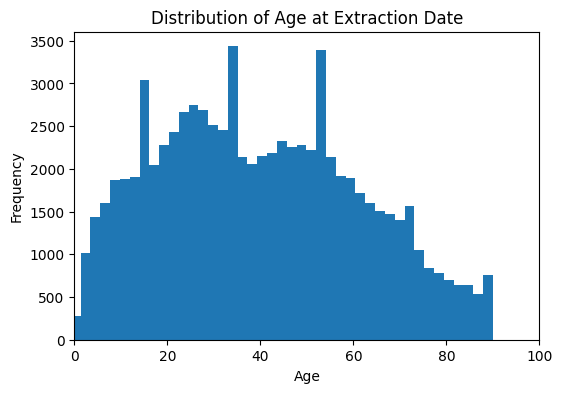

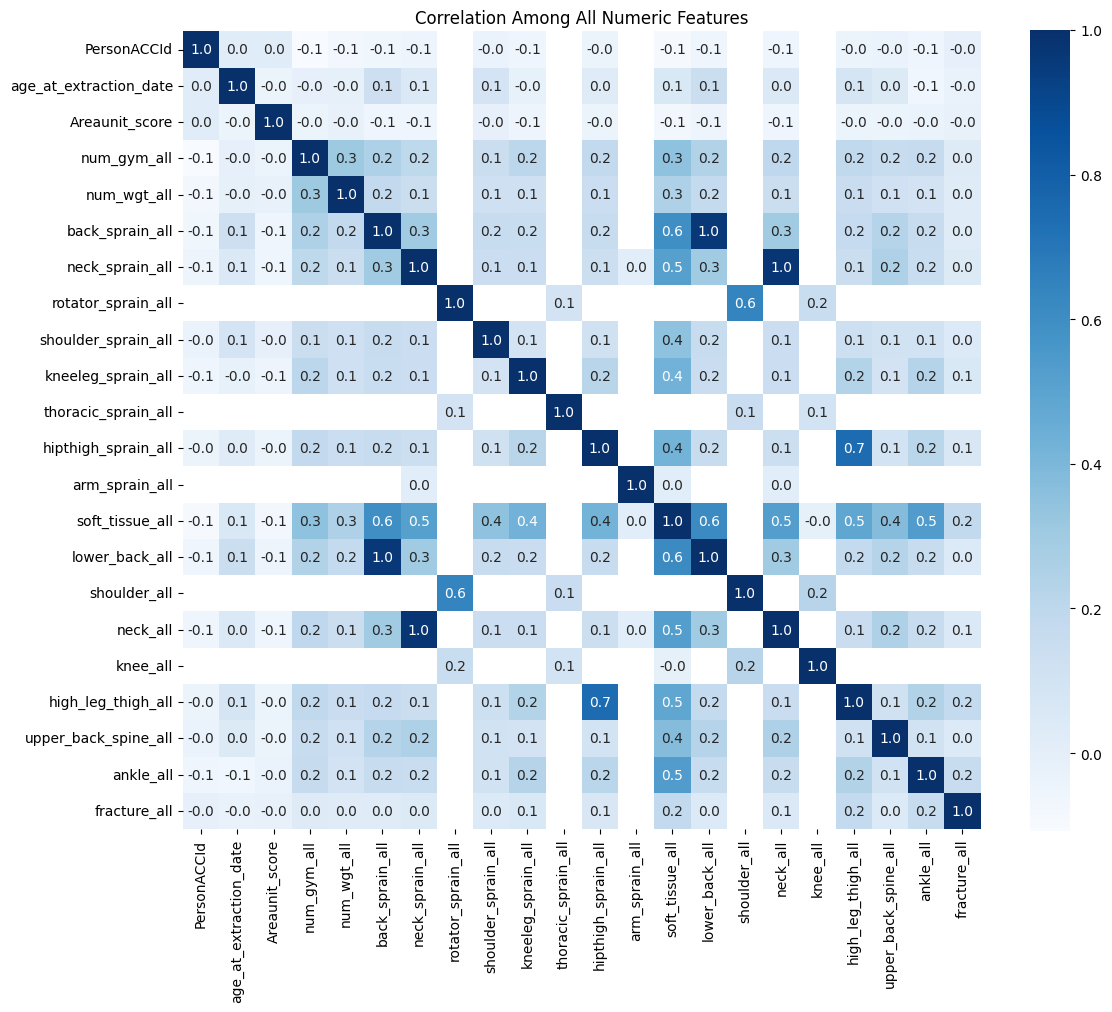

In [6]:
# 4. BASIC EXPLORATORY DATA ANALYSIS (EDA)
# -------------------------------------------------------------

# Example: distribution of age
plt.figure(figsize=(6, 4))
plt.hist(gym_injuries_df['age_at_extraction_date'], bins=90, range=(-100, 90))
plt.title('Distribution of Age at Extraction Date')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.show()

# Example: correlation heatmap of numeric features
# (May need to select a subset of columns if you have many "sprain_all" fields.)
numeric_subset = gym_injuries_df.select_dtypes(include=[np.number])
corr = numeric_subset.corr()

# Mask near-zero correlations
mask = np.abs(corr) < 0.01  # Mask values very close to 0
corr_masked = corr.mask(mask)

plt.figure(figsize=(12, 10))  # Increased figure size for better readability
sns.heatmap(corr_masked, annot=True, cmap='Blues', fmt='.1f', 
            mask=mask,  # Apply mask to hide near-zero correlations
            square=True)
plt.title('Correlation Among All Numeric Features')
plt.xticks(rotation=90, ha='center')  # Changed rotation to 90 degrees
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()




5. FEATURE ENGINEERING


Key Decisions

We have individuals with age anomaly values (-1047, 0 to - 15). 

We will drop records with age_at_extraction_date < 0 and age_at_extraction_date < 15.

Reason: By NZ's standards, individuals can legally go to gym unsupervised at 16 years of age.


In [7]:
# 5. FEATURE ENGINEERING
# -------------------------------------------------------------

# exclude records with age_at_extraction_date < 0 and age_at_extraction_date < 15
gym_injuries_df = gym_injuries_df[gym_injuries_df['age_at_extraction_date'] > 15]
len(gym_injuries_df)


68076

In [8]:
# Fill missing values with mode for numeric variable
# We used mode to highlight the most ocurring value for the deprivation zone 
gym_injuries_df['Areaunit_score'] = gym_injuries_df['Areaunit_score'].fillna(gym_injuries_df['Areaunit_score'].mode()[0])

# Label-encode categorical features (e.g., ethnicity, location, work type)
# Create dummy variables for ethnicity since it's categorical with no ordinal relationship
ethnicity_dummies = pd.get_dummies(gym_injuries_df['ethnicity_last_claim'], prefix='ethnicity')
gym_injuries_df = pd.concat([gym_injuries_df, ethnicity_dummies], axis=1)

# Create dummy variables for location_tla_last_claim
location_dummies = pd.get_dummies(gym_injuries_df['location_tla_last_claim'], prefix='location')
gym_injuries_df = pd.concat([gym_injuries_df, location_dummies], axis=1)

# Create dummy variables for work_last_claim, replacing NA with "Not Stated"
gym_injuries_df['work_last_claim'] = gym_injuries_df['work_last_claim'].fillna('Not Stated')
work_dummies = pd.get_dummies(gym_injuries_df['work_last_claim'], prefix='work')
gym_injuries_df = pd.concat([gym_injuries_df, work_dummies], axis=1)

# Encode accident year. This gives us a value that is closer to the current year to determine recency of claim.
# The higher the value, the more recent the claim thus higher risk.
le = LabelEncoder()
gym_injuries_df['acci_year'] = le.fit_transform(gym_injuries_df['acci_year'])
encoders = {'acci_year': le}

# Drop original categorical columns since we now have dummy variables
gym_injuries_df = gym_injuries_df.drop(['ethnicity_last_claim', 'location_tla_last_claim', 'work_last_claim'], axis=1)

# Create a total injuries feature by summing all prior injuries
# This gives us a total number of injuries for each individual.
injury_cols = [
    'num_gym_all', 'num_wgt_all', 'back_sprain_all', 'neck_sprain_all',
    'rotator_sprain_all', 'shoulder_sprain_all', 'kneeleg_sprain_all',
    'thoracic_sprain_all', 'hipthigh_sprain_all', 'arm_sprain_all',
    'soft_tissue_all', 'lower_back_all', 'shoulder_all', 'neck_all',
    'knee_all', 'high_leg_thigh_all', 'upper_back_spine_all',
    'ankle_all', 'fracture_all'
]


# Create a total injuries feature by summing all prior injuries
gym_injuries_df['total_past_injuries'] = gym_injuries_df[injury_cols].sum(axis=1)

# Convert the target "response" from Y/N to 1/0
gym_injuries_df['response_binary'] = gym_injuries_df['outcome'].map({'Y': 1, 'N': 0})

In [9]:
# Check data types
gym_injuries_df.dtypes

PersonACCId                        int64
age_at_extraction_date           float64
Areaunit_score                   float64
num_gym_all                        int64
num_wgt_all                        int64
back_sprain_all                    int64
neck_sprain_all                    int64
rotator_sprain_all                 int64
shoulder_sprain_all                int64
kneeleg_sprain_all                 int64
thoracic_sprain_all                int64
hipthigh_sprain_all                int64
arm_sprain_all                   float64
soft_tissue_all                    int64
lower_back_all                     int64
shoulder_all                       int64
neck_all                           int64
knee_all                           int64
high_leg_thigh_all                 int64
upper_back_spine_all               int64
ankle_all                          int64
fracture_all                       int64
acci_year                          int64
outcome                           object
ethnicity_Asian 

6. SPLIT DATA INTO FEATURES (X) AND TARGET (y), THEN TRAIN/TEST


In [10]:
# 6. SPLIT DATA INTO FEATURES (X) AND TARGET (y), THEN TRAIN/TEST
# -------------------------------------------------------------

# Define the feature columns
feature_cols = ['age_at_extraction_date', 'Areaunit_score',
       'num_gym_all', 'num_wgt_all', 'back_sprain_all', 'neck_sprain_all',
       'rotator_sprain_all', 'shoulder_sprain_all', 'kneeleg_sprain_all',
       'thoracic_sprain_all', 'hipthigh_sprain_all', 'arm_sprain_all',
       'soft_tissue_all', 'lower_back_all', 'shoulder_all', 'neck_all',
       'knee_all', 'high_leg_thigh_all', 'upper_back_spine_all', 'ankle_all',
       'fracture_all', 'acci_year', 'ethnicity_Asian', 'ethnicity_European',
       'ethnicity_Maori', 'ethnicity_Other Ethnicity', 'ethnicity_Pacific Peoples',
       'ethnicity_Residual Categories', 'location_Auckland City',
       'location_Christchurch City', 'location_Dunedin City',
       'location_Hamilton City', 'location_Manukau City',
       'location_North Shore City', 'location_Tauranga City',
       'location_Unknown', 'location_Wellington City',
       'location_Whangarei District', 'work_Heavy Work', 'work_Light Work',
       'work_Medium Work', 'work_Not Stated', 'work_Sedentary Work',
       'work_Unknown', 'work_Very Heavy Work', 'total_past_injuries'
       ]

X = gym_injuries_df[feature_cols]
y = gym_injuries_df['response_binary']

# We use a 70/30 split, depending on dataset size
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

7. MODEL BUILDING & TRAINING (LOGISTIC REGRESSION EXAMPLE)

In [11]:
# 7. MODEL BUILDING & TRAINING (LOGISTIC REGRESSION EXAMPLE)
# -------------------------------------------------------------
# For demonstration, we’ll use a simple Logistic Regression:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     19300
           1       0.56      0.10      0.17      1123

    accuracy                           0.95     20423
   macro avg       0.75      0.55      0.57     20423
weighted avg       0.93      0.95      0.93     20423

AUC: 0.817
Confusion Matrix:
 [[19210    90]
 [ 1009   114]]


8. MODEL EVALUATION


In [ ]:
# 8. MODEL EVALUATION
# -------------------------------------------------------------
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Predicted probability of class=1

# Print a classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate and print AUC
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc_score:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

9. RANK INDIVIDUALS BY PREDICTED RISK AND DISPLAY CHARTS FOR INSIGHTS

In [20]:
# 9. RANK INDIVIDUALS BY PREDICTED RISK
# -------------------------------------------------------------
# Now that the model is trained, we can generate risk scores for ALL data
# (or just the test set if you prefer). We'll use the entire dataset here
# as an example of how you'd rank everyone.

gym_injuries_df['predicted_prob'] = model.predict_proba(X)[:, 1]

# Sort by predicted probability of experiencing a gym injury (descending)
gym_injuries_df_sorted = gym_injuries_df.sort_values(by='predicted_prob', ascending=False)

# Select the top 500 individuals
top_500 = gym_injuries_df_sorted.head(500)

# Show some columns of interest
print(top_500[['PersonACCId', 'predicted_prob', 'num_gym_all', 'num_wgt_all', 'total_past_injuries']].head(10))

# This list (top_500) would be your recommended group for the free PT sessions.

       PersonACCId  predicted_prob  num_gym_all  num_wgt_all  \
2246          2247        1.000000            7           12   
66614        66615        0.999991            8            2   
1953          1954        0.999961           10            2   
3985          3986        0.999925            7            5   
2453          2454        0.999909            4            5   
1592          1593        0.999905           11            0   
3859          3860        0.999853            6            4   
73271        73272        0.999841            5            4   
560            561        0.999799            6            6   
1014          1015        0.999746            2            5   

       total_past_injuries  
2246                 132.0  
66614                131.0  
1953                  73.0  
3985                  76.0  
2453                 119.0  
1592                  51.0  
3859                  79.0  
73271                101.0  
560                   54.0  
1014 

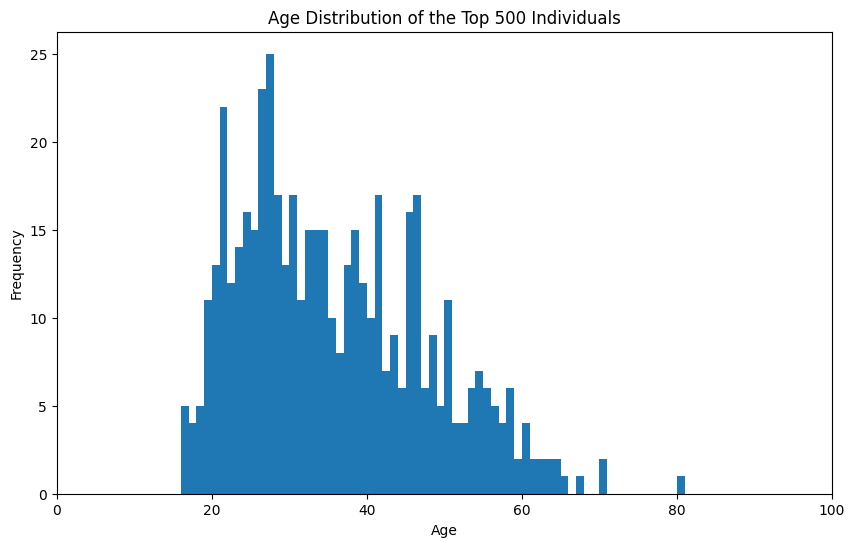

In [13]:
# Distribution of teh top 500 individuals by age
plt.figure(figsize=(10, 6))
plt.hist(top_500['age_at_extraction_date'], bins=90, range=(0, 90))
plt.title('Age Distribution of the Top 500 Individuals')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.show()


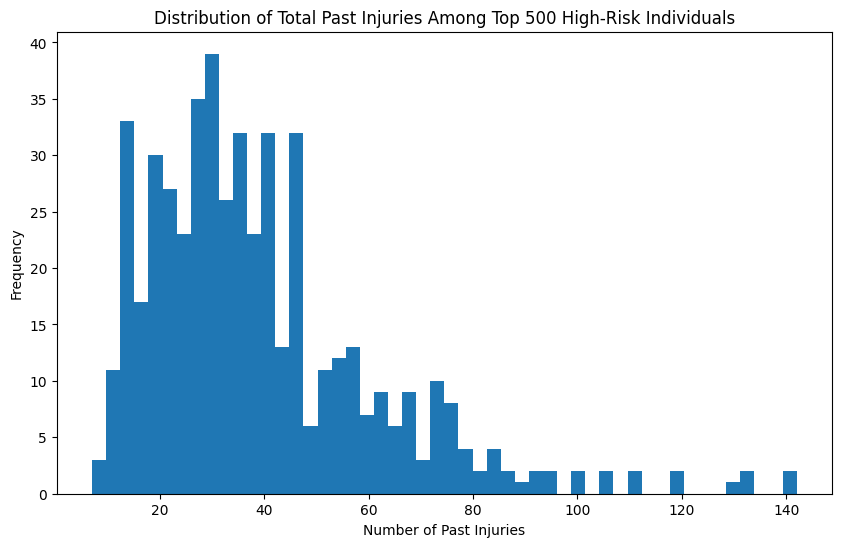

In [14]:
# chart of the top 500 individuals by total past injuries
plt.figure(figsize=(10, 6))
plt.hist(top_500['total_past_injuries'], bins=50)
plt.title('Distribution of Total Past Injuries Among Top 500 High-Risk Individuals')
plt.xlabel('Number of Past Injuries')
plt.ylabel('Frequency')
plt.show()

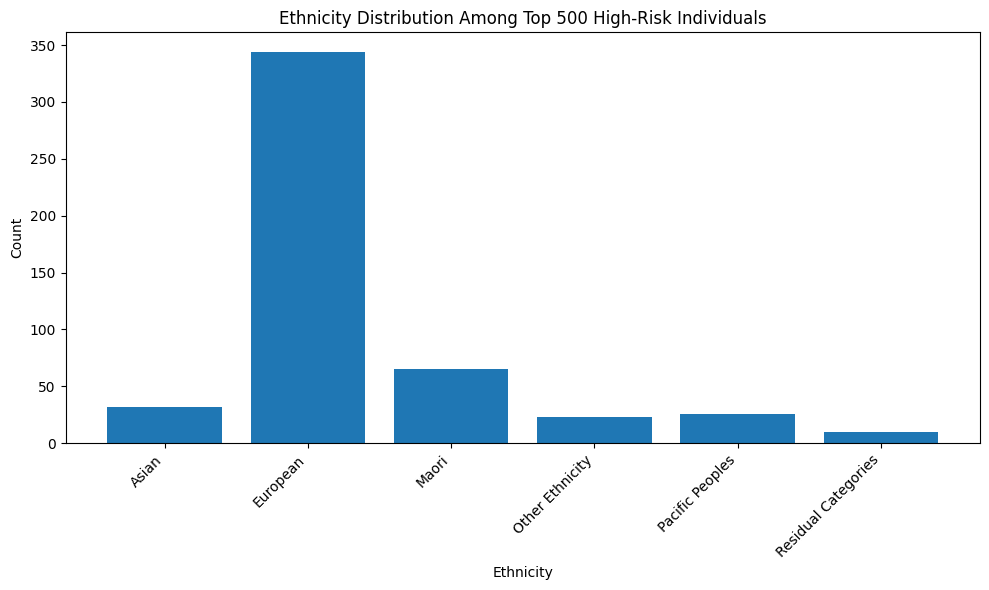

In [15]:
# chart of ethnicity distribution among top 500 high-risk individuals
ethnicity_cols = [col for col in top_500.columns if col.startswith('ethnicity_')]
ethnicity_counts = top_500[ethnicity_cols].sum()

plt.figure(figsize=(10, 6))
plt.bar(ethnicity_counts.index.str.replace('ethnicity_', ''), ethnicity_counts.values)
plt.title('Ethnicity Distribution Among Top 500 High-Risk Individuals')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

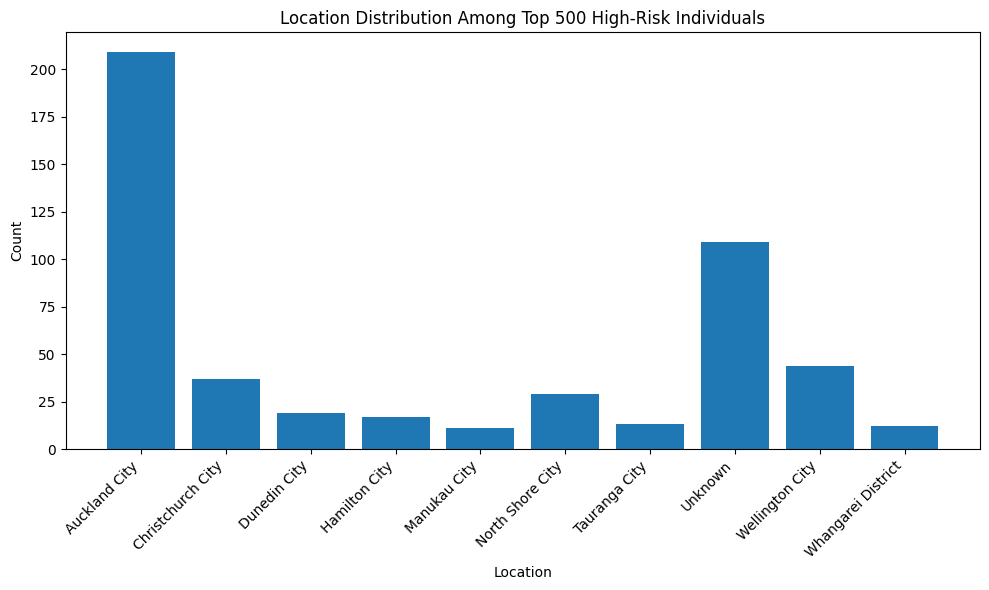

In [16]:
# chart of location distribution among top 500 high-risk individuals
location_cols = [col for col in top_500.columns if col.startswith('location_')]
location_counts = top_500[location_cols].sum()

plt.figure(figsize=(10, 6))
plt.bar(location_counts.index.str.replace('location_', ''), location_counts.values)
plt.title('Location Distribution Among Top 500 High-Risk Individuals')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


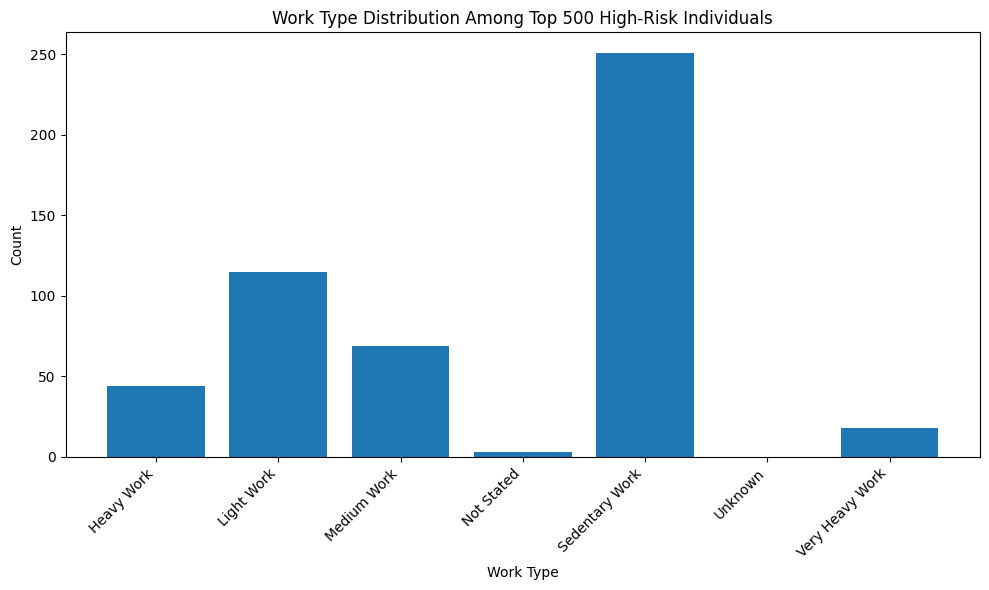

In [17]:
# chart of work type distribution among top 500 high-risk individuals
work_cols = [col for col in top_500.columns if col.startswith('work_')]
work_counts = top_500[work_cols].sum()

plt.figure(figsize=(10, 6))
plt.bar(work_counts.index.str.replace('work_', ''), work_counts.values)
plt.title('Work Type Distribution Among Top 500 High-Risk Individuals')
plt.xlabel('Work Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
